In [11]:
import pyscf
import pyqmc.api as pyq
import numpy as np
import pyscf.mcscf
import matplotlib.pyplot as plt
import pyqmc.energy as energy
from pyqmc.mc import limdrift

In [12]:
mol = pyscf.gto.M(
    atom="""
         H 0. 0. 0.;
         H 0. 0. 2.0
         """,
    ecp="ccecp",
    basis="ccecpccpvdz",
    unit="bohr",
    verbose=5,
)

System: uname_result(system='Darwin', node='wirelessprv-10-192-9-166.near.illinois.edu', release='23.4.0', version='Darwin Kernel Version 23.4.0: Wed Feb 21 21:44:54 PST 2024; root:xnu-10063.101.15~2/RELEASE_ARM64_T6030', machine='arm64')  Threads 1
Python 3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]
numpy 2.0.2  scipy 1.15.2  h5py 3.12.1
Date: Sun May  4 10:41:55 2025
PySCF version 2.7.0
PySCF path  /opt/anaconda3/envs/qmc/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = bohr
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 H  

In [13]:
mf = pyscf.scf.RHF(mol)
mf.kernel()



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/tmpd8p71edf
max_memory 4000 MB (current use 0 MB)
cond(S) = 67.45169312325919
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
E1 = -1.9471474368657122  E_coul = 0.6976322822459868
init E= -0.749515154619725
    CPU time for initialize scf      0.01 sec, wall time      0.01 sec
  HOMO = -0.426068316512957  LUMO = 0.0849316875203985
  mo_energy =
[-0.42606832  0.08493169  0.70047972  0.84460627  1.31883732  1.31883732
  1.65015221  1.85964567  1.85964567  2.67875606]
E1 = -2.143094776391732  E_coul = 0.5532133356021937
cycle= 1 E= -1.08988144078954  delta_E= -0.34  |g|= 0.043  

np.float64(-1.0905378313306202)

In [14]:
wf, to_opt = pyq.generate_slater(mol, mf)
grad = pyq.gradient_generator(mol, wf)

configs = pyq.initial_guess(mol, 100)
nconf, nelec, _ = configs.configs.shape
time_step = 2.0

wf.recompute(configs)

coulomb = energy.OpenCoulomb(mol)
ee, ei, ii = coulomb.energy(configs)

In [15]:
def vmc_worker_modified(wf, configs, tstep, nsteps, grads):
    """
    Run VMC for nsteps with enhanced error estimation.
    Returns both block averages and standard deviations.
    """
    nconf, nelec, _ = configs.configs.shape
    block_avg = {}
    block_std = {}
    step_data = {}  # Store per-step data for standard deviation calculation
    
    wf.recompute(configs)

    for step in range(nsteps):
        acc = 0.0
        for e in range(nelec):
            # Propose move (same as original)
            g, _, _ = wf.gradient_value(e, configs.electron(e))
            grad = limdrift(np.real(g.T))
            gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
            newcoorde = configs.configs[:, e, :] + gauss + grad * tstep
            newcoorde = configs.make_irreducible(e, newcoorde)

            # Compute reverse move (same as original)
            g, new_val, saved = wf.gradient_value(e, newcoorde)
            new_grad = limdrift(np.real(g.T))
            forward = np.sum(gauss**2, axis=1)
            backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

            # Acceptance (same as original)
            t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
            ratio = np.abs(new_val) ** 2 * t_prob
            accept = ratio > np.random.rand(nconf)

            # Update wave function (same as original)
            configs.move(e, newcoorde, accept)
            wf.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saved)
            acc += np.mean(accept) / nelec

        # Collect data for this step
        step_results = {}
        dat = grads.avg(configs, wf)
        for m, res in dat.items():
            key = m
            if key not in step_data:
                step_data[key] = []
            step_data[key].append(res)
            
            # Also update rolling average
            if key not in block_avg:
                block_avg[key] = res / nsteps
            else:
                block_avg[key] += res / nsteps
        
        block_avg["acceptance"] = acc
    
    # Calculate standard deviations for each accumulated quantity
    for key, values in step_data.items():
        if len(values) > 1:  # Need at least 2 points for std
            block_std[key] = np.std(values, axis=0) / np.sqrt(len(values))
        else:
            block_std[key] = np.zeros_like(values[0])
    
    # Add acceptance rate std (if we had tracked per-step acceptance)
    block_std["acceptance"] = 0.0  # Placeholder
    
    return block_avg, block_std, configs

def vmc_modified(
    wf,
    configs,
    tstep=0.5,
    nblocks=10,
    nsteps_per_block=20,  # Increased from default 10
    grad=None,
    verbose=False,
    equilibration_blocks=2,  # Add equilibration phase
):

    for _ in range(equilibration_blocks):
        _, _, configs = vmc_worker_modified(
            wf, configs, tstep, nsteps_per_block, grad
        )
    
    if verbose:
        print(f"Starting production: {nblocks} blocks of {nsteps_per_block} steps each")
    
    df_avg = []
    df_std = []

    # Production phase
    for block in range(nblocks):
        if verbose:
            print(f"Block {block+1}/{nblocks}", end="\r", flush=True)
        
        block_avg, block_std, configs = vmc_worker_modified(
            wf, configs, tstep, nsteps_per_block, grad
        )
        
        # Add block number
        block_avg["block"] = block
        block_std["block"] = block
        
        # Add configuration count
        block_avg["nconfig"] = nsteps_per_block * configs.configs.shape[0]
        block_std["nconfig"] = 0
        
        df_avg.append(block_avg)
        df_std.append(block_std)
    
    if verbose:
        print("\nVMC calculation complete")

    # Format return values
    df_avg_return = {}
    df_std_return = {}
    
    if len(df_avg) > 0:
        for k in df_avg[0].keys():
            df_avg_return[k] = np.asarray([d[k] for d in df_avg])
            if k in df_std[0]:
                df_std_return[k] = np.asarray([d[k] for d in df_std])
    
    return df_avg_return, df_std_return, configs




In [16]:
results_lucas = vmc_modified(wf,
                            configs, 
                            tstep = 2.0,
                            nblocks = 30,
                            nsteps_per_block=1000,
                            grad = grad,
                            verbose = False,
                            equilibration_blocks=100)

In [17]:
results_lucas

({'ke': array([0.85798771, 0.87544619, 0.87102428, 0.87559234, 0.86850969,
         0.88767582, 0.86248448, 0.88135791, 0.88756533, 0.89173891,
         0.87230664, 0.87775014, 0.87410509, 0.8756221 , 0.8882783 ,
         0.8735605 , 0.88494676, 0.89871981, 0.89056895, 0.87065631,
         0.84496569, 0.86260457, 0.88427479, 0.86656464, 0.86828292,
         0.86321955, 0.86930876, 0.87589921, 0.86661513, 0.86602928]),
  'ee': array([0.55555232, 0.56301678, 0.5579562 , 0.5626607 , 0.55978792,
         0.56190258, 0.55986185, 0.55984871, 0.55922127, 0.55999413,
         0.55559325, 0.56084791, 0.5630383 , 0.56028083, 0.56191595,
         0.562281  , 0.56658669, 0.56643925, 0.5574584 , 0.55933894,
         0.55818506, 0.56420827, 0.55878524, 0.56172346, 0.5625255 ,
         0.55540168, 0.55988026, 0.5646274 , 0.56297579, 0.55185705]),
  'ei': array([-3.00283343, -3.03200004, -3.01621638, -3.02340454, -3.01788134,
         -3.03667401, -3.0128865 , -3.0305193 , -3.04410252, -3.04087555,
  

In [61]:
results_lucas[0]["total"]

array([-1.08840828, -1.08553038, -1.08705372, -1.08888845, -1.09279671,
       -1.08939407, -1.08787752, -1.09361816, -1.09115838, -1.08877214,
       -1.09156158, -1.08797686, -1.0870438 , -1.09153466, -1.09011062,
       -1.08929607, -1.09272884, -1.09482842, -1.09100113, -1.09156349,
       -1.09383835, -1.08907744, -1.09427819, -1.09000797, -1.09000816,
       -1.08805342, -1.09407754, -1.08964048, -1.09052778, -1.08959161])

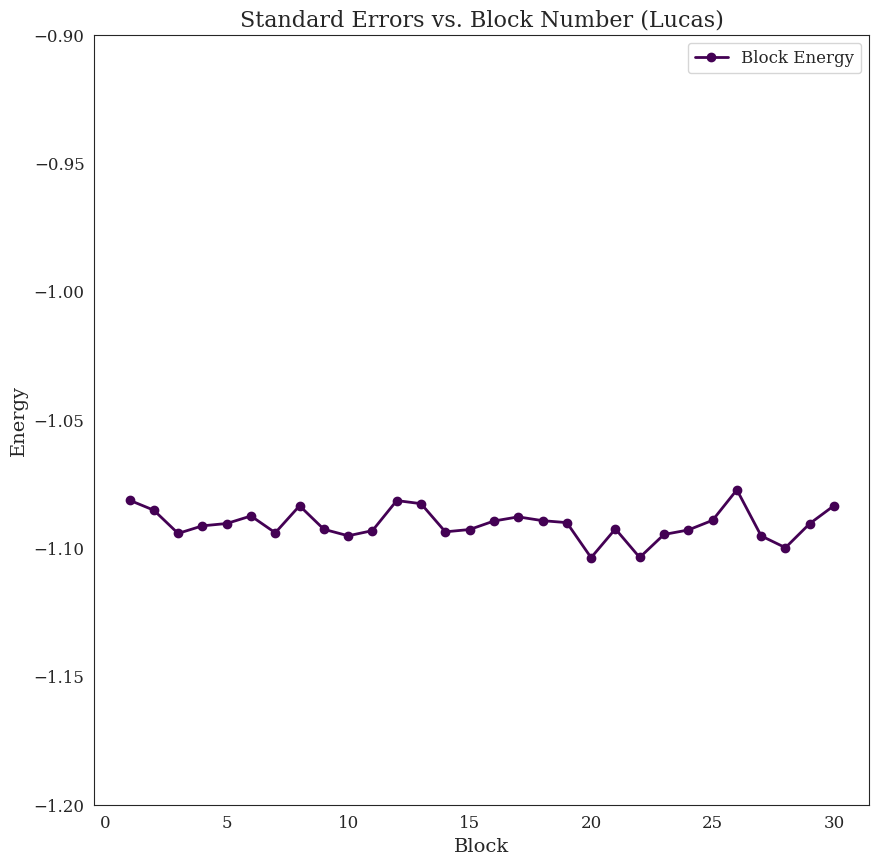

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from matplotlib.gridspec import GridSpec
from scipy import stats
sns.set_style("white")
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.titlesize'] = 16

plt.figure(figsize=(10, 10))
block_offset = 0
block_energies = np.array(results_lucas[0]["total"])
blocks = np.arange(block_offset + 1, block_offset + 1 + len(results_lucas[0]["total"]))
colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.plot(blocks, block_energies, lw=2, marker='o', linestyle='-', color=colors[0], label='Block Energy')
plt.ylim([-1.2, -0.9])
plt.xlabel('Block', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Standard Errors vs. Block Number (Lucas)', fontsize=16)
plt.savefig("Lucas_2.png", dpi=300, bbox_inches='tight')
plt.legend()

In [15]:
configs = pyq.initial_guess(mol, 100)

wf, to_opt = pyq.generate_slater(mol, mf)
grad = pyq.gradient_generator(mol, wf)

nconf, nelec, _ = configs.configs.shape
time_step = 2.0
configs = pyq.initial_guess(mol, 100)
coulomb = energy.OpenCoulomb(mol)
nsteps_per_block = 100
wf.recompute(configs)

block_energies_local = {}
block_energies_std = {}
nblocks = 50
block_energies_local = []
block_energies_std = []

for block in range(nblocks):
    
    # 블록 내 통계 초기화
    block_acc = 0.0

    # 파동함수 재계산 (매 블록 시작 시)
    wf.recompute(configs)    
    # 블록 내 단계 실행
    for step in range(nsteps_per_block):
        # 각 전자에 대해 이동 제안
        acc = 0.0
        prev_configs = configs.configs.copy()
        
        for e in range(nelec):
            # 이동 제안
            g, _, _ = wf.gradient_value(e, configs.electron(e))
            grad = limdrift(np.real(g.T))
            gauss = np.random.normal(scale=np.sqrt(time_step), size=(nconf, 3))
            newcoorde = configs.configs[:, e, :] + gauss + grad * time_step
            newcoorde = configs.make_irreducible(e, newcoorde)
            
            # 역방향 이동 계산
            g, new_val, saved = wf.gradient_value(e, newcoorde)
            new_grad = limdrift(np.real(g.T))
            
            # 전이 확률 계산
            forward = np.sum(gauss**2, axis=1)
            backward = np.sum((gauss + time_step * (grad + new_grad)) ** 2, axis=1)
            t_prob = np.exp(1 / (2 * time_step) * (forward - backward))
            
            # 수용률 계산
            ratio = np.abs(new_val) ** 2 * t_prob
            accept = ratio > np.random.rand(nconf)
            
            # 좌표 및 파동함수 업데이트
            configs.move(e, newcoorde, accept)
            wf.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saved)
            acc += np.mean(accept) / nelec
        
        print(configs.configs[0][0][0])
        coulomb = energy.OpenCoulomb(mol)
        ee, ei, ii = coulomb.energy(configs)
        ke, grad2 = energy.kinetic(configs, wf)
        
        total = ee + ei + ii + ke
        block_acc += acc
    
    acc = block_acc/nsteps_per_block
    # print(acc)
    std_dev = np.std(total, axis = 0) / np.sqrt(nsteps_per_block)
    mean_energy = np.mean(total, axis = 0)
        
    block_energies_local.append(mean_energy)
    block_energies_std.append(std_dev)

-0.21302270886960972
-0.21302270886960972
-0.21302270886960972
-0.8300631779889349
-0.8300631779889349
-0.8300631779889349
-0.3510416716961182
0.0042299526008289234
-0.4296400664287131
1.98175344118842
1.5778797338133752
-0.86233423773197
-0.86233423773197
-0.8298782423148892
0.8878628590753445
3.8931138156977783
3.5172020634989147
0.5014284236386455
-0.24415563361756756
-1.21257058195993
-0.6930795858989831
0.30559896183403723
2.313794207531834
0.21782529328688538
0.21782529328688538
-0.5259789985589031
-0.5259789985589031
-0.5259789985589031
0.9835707515512747
0.9835707515512747
0.9835707515512747
-0.07436280049239086
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
0.26996773014325914
-0.525888878

In [16]:
block_energies_local

[np.float64(-1.125970334664911),
 np.float64(-1.140576471383994),
 np.float64(-1.1518612806433832),
 np.float64(-1.0847808557131444),
 np.float64(-1.071336436239414),
 np.float64(-0.9064334384883641),
 np.float64(-1.5170174981896825),
 np.float64(-1.1219615260540627),
 np.float64(-0.9889745398059775),
 np.float64(-1.139126825602674),
 np.float64(-1.1088470462662174),
 np.float64(-1.1206631827152136),
 np.float64(-1.0860654419963753),
 np.float64(-1.1903963530990118),
 np.float64(-1.1338704172547376),
 np.float64(-1.0738865380717948),
 np.float64(-1.0827086201565366),
 np.float64(-1.0794892030454308),
 np.float64(-1.086831672178524),
 np.float64(-1.0788549743867606),
 np.float64(-1.130759883124691),
 np.float64(-1.0734813821950475),
 np.float64(-1.1504474335184056),
 np.float64(-1.1369431899933955),
 np.float64(-1.0895235890270258),
 np.float64(-1.1702188563799447),
 np.float64(-1.1217565809909062),
 np.float64(-1.077127772886676),
 np.float64(-1.061036056212659),
 np.float64(-1.1411944

In [17]:
block_energies_std

[np.float64(0.02494856284197034),
 np.float64(0.03377529514356865),
 np.float64(0.046904223726181214),
 np.float64(0.0321103713896103),
 np.float64(0.029857374495297163),
 np.float64(0.029602459921404124),
 np.float64(0.05642437133754193),
 np.float64(0.030041864931298717),
 np.float64(0.10181512558205734),
 np.float64(0.04054441411128533)]

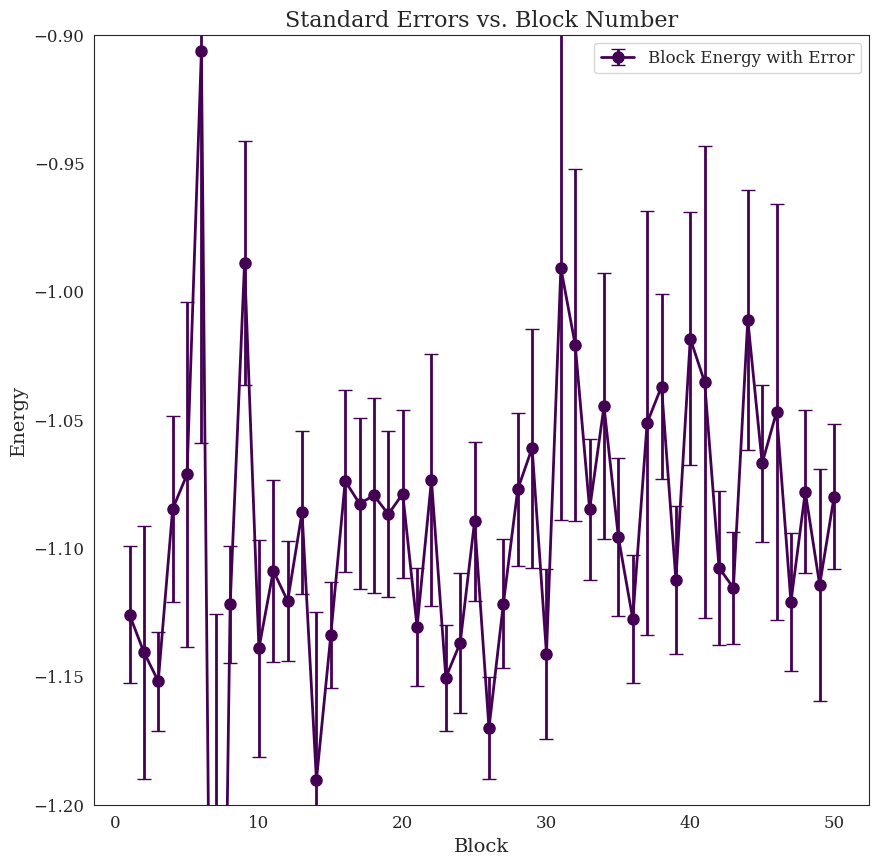

In [48]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from matplotlib.gridspec import GridSpec
from scipy import stats
sns.set_style("white")
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.titlesize'] = 16

plt.figure(figsize=(10, 10))
block_offset = 0
block_energies = np.array(block_energies_local)
block_erros = np.array(block_energies_std)
blocks = np.arange(block_offset + 1, block_offset + 1 + len(block_energies))
colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.errorbar(blocks, block_energies, yerr = block_erros, fmt='o-', 
                color=colors[0], ecolor=colors[0], capsize=5, 
                lw=2, markersize=8, label='Block Energy with Error')
plt.ylim([-1.2, -0.9])
plt.xlabel('Block', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Standard Errors vs. Block Number', fontsize=16)
plt.savefig("Lucas.png", dpi=300, bbox_inches='tight')
plt.legend()